In [29]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
current_script_path = os.getcwd()
module_path = os.path.join(current_script_path, '..')
sys.path.append(os.path.abspath(module_path))
from utilities.Obtainer import RotationalFiltersObtainer
import torch
import torch.nn.functional as F
device = 'cpu'
plt.rcParams.update({'font.size': 14})

# Generate data

In [ ]:
def gabor_generator(xx, yy, cos_freq, cos_phase, gaussian_var, x_enlarge_factor=1, y_enlarge_factor=1, gaussian_aspect_ratio=1, theta=0, coordinate_system='cartesian'):

    # Rotate the coordinate
    def rotate_coords(x, y, theta):
        x_rot = x * np.cos(theta) - y * np.sin(theta)
        y_rot = x * np.sin(theta) + y * np.cos(theta)
        return x_rot, y_rot

    # Gabor generator
    def gabor_cartesian(x, y):
        x_rot, y_rot = rotate_coords(x, y, theta)
        return np.exp(-((x_rot/x_enlarge_factor)**2 + gaussian_aspect_ratio**2 * (y_rot/y_enlarge_factor)**2) / (2 * gaussian_var**2)) * np.cos(2 * np.pi * x_rot * cos_freq + cos_phase)

    return gabor_cartesian(xx, yy)

def generate_gabor_input(xx, yy, cos_freq=1.5, cos_phase=0, gaussian_var=0.3, x_enlarge_factor=1, y_enlarge_factor=1, gaussian_aspect_ratio=1, theta=np.pi/4, contrast=0.5, if_plot=False,**kwargs):
    gabor = gabor_generator(xx, yy, cos_freq=cos_freq, cos_phase=cos_phase, gaussian_var=gaussian_var, x_enlarge_factor=x_enlarge_factor, y_enlarge_factor=y_enlarge_factor, gaussian_aspect_ratio=gaussian_aspect_ratio, theta=theta)
    gabor = (gabor-np.min(gabor))/(np.max(gabor)-np.min(gabor))*contrast

    if if_plot:
        # Show the results
        plt.imshow(gabor, cmap='gray', extent=(-1, 1, -1, 1),vmin=0,vmax=1)
        plt.colorbar()
        plt.show()
    
    return gabor

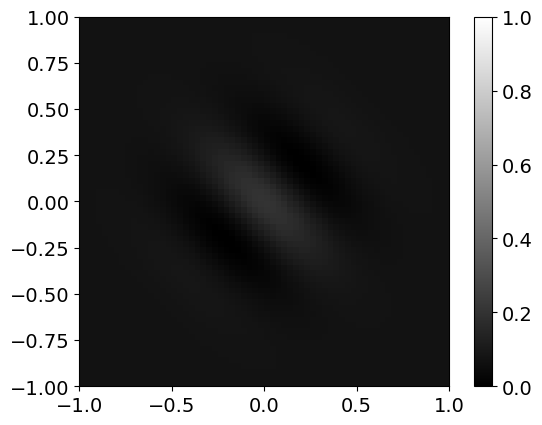

In [3]:
x = np.linspace(-1,1,64)
y = np.linspace(-1,1,64)
xx, yy = np.meshgrid(x, y, indexing='xy')
gabor = generate_gabor_input(xx, yy, cos_freq=1.5, cos_phase=0, gaussian_var=0.3, gaussian_aspect_ratio=1, theta=np.pi/4, contrast=0.2, if_plot=True)

# Model

In [31]:
def single_gaussian(theta, center, size_ext, periodic=True):
    if periodic: 
        return torch.exp(-(theta - center)**2/(2*size_ext**2))+torch.exp(-(theta - center+180)**2/(2*size_ext**2))+torch.exp(-(theta - center-180)**2/(2*size_ext**2))
    else:
        return torch.exp(-(theta - center)**2/(2*size_ext**2))

def K_XY(N,theta,G_XY,sigma=25):
    K_XY = torch.zeros((N,N),device=device)
    for i in range(N):
        for j in range(N):
            K_XY[i,j]= G_XY*single_gaussian(theta[j],theta[i],sigma)
    return K_XY.double()

class Model:
    def __init__(self, Gabor,g_EE,g_EI,g_IE,K,iterations=10,bias = -100,relu_type='relu'):
        self.Gabor = Gabor
        self.g_EE = g_EE
        self.g_EI = g_EI
        self.g_IE = g_IE
        self.G_EE = g_EE*K.to(device)
        self.G_EI = g_EI*K.to(device)
        self.G_IE = g_IE*K.to(device)
        self.iterations = iterations
        self.bias = bias
        self.relu_type = relu_type

    def forward(self, x, alpha=0.1,I_I = 0):
        # Compute Gabor filter output
        if self.relu_type == 'relu':
            sigma = torch.relu
        else:
            sigma = F.leaky_relu

        Gabor_x = torch.matmul(self.Gabor, x)+self.bias

        r_E = sigma(Gabor_x).to(device)
        r_I = sigma(Gabor_x-Gabor_x+I_I).to(device)
        for iters in range(self.iterations):
            r_E_old = r_E
            r_I_old = r_I
            r_E = alpha*sigma(Gabor_x+torch.matmul(self.G_EE,r_E)-torch.matmul(self.G_EI,r_I))+(1-alpha)*r_E_old
            r_I = alpha*sigma(I_I+torch.matmul(self.G_IE,r_E))+(1-alpha)*r_I_old
        r_E = sigma(Gabor_x+torch.matmul(self.G_EE,r_E)-torch.matmul(self.G_EI,r_I))

        self.r_I = r_I

        y = r_E

        return y

    def compute_loss(self, x, y_true):
        # Compute model output
        y = self.forward(x)
        y_true = y_true.double()

        # Compute cross entropy loss
        loss = F.mse_loss(y[[90,0]].unsqueeze(0), y_true[[90,0]].unsqueeze(0))

        return loss 
    
    def compute_gradient(self, x, y_true):
        # Ensure x requires gradient
        x.requires_grad_(True)

        # Zero the gradients of x
        if x.grad is not None:
            x.grad.detach_()
            x.grad.zero_()

        # Compute loss
        loss = self.compute_loss(x, y_true)

        # Compute gradients
        loss.backward()

        # Return gradient of loss with respect to x
        return x.grad

    
    def zero_grad(self):
        if self.Gabor.grad is not None:
            self.Gabor.grad.detach_()
            self.Gabor.grad.zero_()

In [32]:
N = 180
theta = torch.arange(N)/N*180
K = K_XY(N,theta,1)

In [6]:
G = torch.from_numpy(RotationalFiltersObtainer.gabor_filters_matrix())
g_EE = 0.01
g_EI = 0.05
g_IE = 0.04
ring = Model(G,g_EE,g_EI,g_IE,K,bias = -5,iterations=2000)

In [ ]:
def compute_max_pertubation(gabor,ring, if_specific_data=False,plot=False):
    response = ring.forward(torch.from_numpy(gabor.reshape(-1,1)))
    index = torch.nonzero(response.reshape(-1))[:,0]
    print(index.shape)
    kernel = torch.inverse(torch.eye(index.shape[0])-ring.G_EE[index][:,index]+ring.G_EI[index][:,index]@ring.G_IE[index][:,index])
    A = (kernel@(ring.Gabor[index]))

    # Compute the SVD for matrix A
    U, S, Vh = torch.linalg.svd(A)

    # Get the largest singular value
    max_singular_value = S[0]

    # Get the left and right singular vectors for the largest singular value
    left_singular_vector = U[:, 0]
    right_singular_vector = Vh[0, :]

    if if_specific_data:
        print("Matrix A:")
        print(A)

        print("\nThe largest singular value is:")
        print(max_singular_value)

        print("\nThe corresponding left singular vector (U[:, 0]):")
        print(left_singular_vector)

        print("\nThe corresponding right singular vector (Vh[0, :]):")
        print(right_singular_vector)

    # plt.imshow(np.asarray(Vh[0, :]).reshape(64,64))
    if plot:
        fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
        for i in range(2):
            for j in range(5):
                img = axes[i, j].imshow(np.asarray(Vh[5*i+j, :]).reshape(64,64),cmap='grey')  
                fig.colorbar(img, ax=axes[i, j])
    return U,S,Vh,response,index,ring.r_I

def different_para_fix_ring(ring, variable_ranges, fixed_params=None,save=False):
    # Set default value if no fixed parameters are provided
    if fixed_params is None:
        fixed_params = {
            'cos_freq': 1, 
            'cos_phase': 0, 
            'gaussian_var': 0.3, 
            'gaussian_aspect_ratio': 1, 
            'theta': np.pi/4, 
            'contrast': 0.5
        }
    
    # Get the variable name and range
    variable_name, variable_values = list(variable_ranges.items())[0]
    
    n_rows = len(variable_values)
    fig, axes = plt.subplots(nrows=n_rows, ncols=5, figsize=(25, 5 * n_rows))

    for i, value in enumerate(variable_values):
        # Update variable parameters
        params = fixed_params.copy()
        params[variable_name] = value  # Update the variable for the current loop
        
        # Generate gabor input
        gabor = generate_gabor_input(xx, yy, **params, if_plot=False)
        
        # Compute the response
        U, S, V, response, index, r_I = compute_max_pertubation(gabor, ring, if_specific_data=False, plot=False)

        # Display the gabor image
        img = axes[i, 0].imshow(np.asarray(gabor).reshape(64, 64), cmap='grey')
        fig.colorbar(img, ax=axes[i, 0])
        axes[i, 0].set_title(f"Gabor({variable_name}={value})")

        # Plot r_E and r_I
        axes[i, 1].plot(np.asarray(response), label='r_E')
        axes[i, 1].plot(np.asarray(r_I), label='r_I')
        axes[i, 1].set_title(f"active range=[{index[0]},{index[-1]}]")
        axes[i, 1].legend()

        # Display the V[0] image
        img = axes[i, 2].imshow(np.asarray(V[0, :]).reshape(64, 64), cmap='grey')
        fig.colorbar(img, ax=axes[i, 2])
        axes[i, 2].set_title(f"Gain = {S[0]}")

        img = axes[i, 3].imshow(np.asarray(V[1, :]).reshape(64, 64), cmap='grey')
        fig.colorbar(img, ax=axes[i, 3])
        axes[i, 3].set_title(f"Gain = {S[1]}")

        mg = axes[i, 4].imshow(np.asarray(V[2, :]).reshape(64, 64), cmap='grey')
        fig.colorbar(img, ax=axes[i, 4])
        axes[i, 4].set_title(f"Gain = {S[2]}")

    plt.tight_layout()

    if save:
        save_path = f"Figure/gEE_{ring.g_EE}_gEI_{ring.g_EI}_gIE_{ring.g_IE}/"
        current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        file_name = f"{variable_name}_{current_time}.png"

        if not os.path.exists(save_path):
            os.makedirs(save_path)
        plt.savefig(save_path+file_name)  # Save the image
    plt.show()

In [ ]:
def plot_gain(ring, variable_ranges, fixed_params=None,save=False,norm=2,mean_times=10):
# Set default values if no fixed parameters are provided
    if fixed_params is None:
        fixed_params = {
            'cos_freq': 1.5, 
            'cos_phase': 0, 
            'gaussian_var': 0.3, 
            'gaussian_aspect_ratio': 1, 
            'theta': np.pi/4, 
            'contrast': 0.5,
            'Gaussian_noise_scale': 0
        }

    variable_name, variable_values = list(variable_ranges.items())[0]

    params = fixed_params.copy()
    base_gabor = generate_gabor_input(xx, yy, **params, if_plot=False)
    U, S, V, base_response, index, r_I = compute_max_pertubation(base_gabor, ring, if_specific_data=False, plot=False)
    delta_gabor_record = []
    delta_response_record = []
    delta_response_record1 = []
    response_record = []

    for i, value in enumerate(variable_values):
        # Update variable parameters
        params = fixed_params.copy()
        params[variable_name] = value  # Update the variable for the current loop
        
        # Generate gabor input
        gabor = generate_gabor_input(xx, yy, **params, if_plot=False)
        if variable_name=='Gaussian_noise_scale':
            delta_gabor = 0
            delta_response = 0
            delta_response1 = 0
            for _ in range(mean_times):
                gabor_noised = gabor+np.random.normal(loc=0.0, scale=params['Gaussian_noise_scale'], size=4096).reshape(64,64)
                U, S, V, response, index, r_I = compute_max_pertubation(gabor_noised, ring, if_specific_data=False, plot=False)
                delta_gabor += np.sqrt(np.sum((gabor_noised-base_gabor)**2))
                delta_response += torch.sqrt(torch.sum((response-base_response)**2))
                delta_response1 += torch.sum(torch.abs(response-base_response))
            delta_gabor_record.append(delta_gabor/10)
            delta_response_record.append(delta_response/10)
            delta_response_record1.append(delta_response1/10)
            response_record.append(response)
            continue
            
        
        # Compute the response
        U, S, V, response, index, r_I = compute_max_pertubation(gabor, ring, if_specific_data=False, plot=False)
        delta_gabor_record.append(np.sqrt(np.sum((gabor-base_gabor)**2)))
        delta_response_record.append(torch.sqrt(torch.sum((response-base_response)**2)))
        delta_response_record1.append(torch.sum(torch.abs(response-base_response)))
        response_record.append(response)

    return np.asarray(delta_gabor_record),np.asarray(delta_response_record),np.asarray(delta_response_record1),np.asarray(response_record)


In [9]:
G = torch.from_numpy(RotationalFiltersObtainer.gabor_filters_matrix())
K = K_XY(N,theta,1,sigma=25)
g_EE = 0.01
g_EI = 0.05
g_IE = 0.04
ring = Model(G,g_EE,g_EI,g_IE,K,bias = -5,iterations=200)

In [10]:
# variable_ranges = {'cos_freq': [0,0.75,1,1.5,2,2.25,3,3.5,4]}
# variable_ranges = {'y_enlarge_factor':np.linspace(1,3,10)}
# variable_ranges = {'x_enlarge_factor':[0.5,0.75,1,1.25,1.5,2]}
# variable_ranges = {'theta':[0,torch.pi/6,torch.pi/4,torch.pi/3,torch.pi/2]}
# variable_ranges = {'cos_phase':[0,torch.pi/6,torch.pi/4,torch.pi/3,torch.pi/2]}
variable_ranges = {'contrast':np.linspace(0.5,0.753,20)}

fixed_params = {
    'cos_phase': 0,
    'gaussian_var': 0.3,
    'gaussian_aspect_ratio': 1,
    'theta': np.pi/4,
    'contrast': 0.5,
    'cos_freq': 1.1,
    'y_enlarge_factor': 0.9,
    'x_enlarge_factor': 1.2
}

delta_gabor_record_contrast,delta_response_record_contrast,delta_response_record_contrast1,response_record_contrast = plot_gain(ring, variable_ranges, fixed_params,norm=2)

torch.Size([89])
torch.Size([89])
torch.Size([89])
torch.Size([91])
torch.Size([91])
torch.Size([91])
torch.Size([91])
torch.Size([91])
torch.Size([93])
torch.Size([93])
torch.Size([93])
torch.Size([93])
torch.Size([93])
torch.Size([93])
torch.Size([93])
torch.Size([95])
torch.Size([95])
torch.Size([95])
torch.Size([95])
torch.Size([95])
torch.Size([95])


In [11]:
# variable_ranges = {'y_enlarge_factor':np.linspace(1,3,20)}

# fixed_params = {
#     'cos_phase': 0,
#     'gaussian_var': 0.3,
#     'gaussian_aspect_ratio': 1,
#     'theta': np.pi/4,
#     'contrast': 0.5,
#     'cos_freq': 0.8,
#     'y_enlarge_factor': 1,
#     'x_enlarge_factor': 1
# }

variable_ranges = {'y_enlarge_factor':np.linspace(0.9,4,20)}
fixed_params = {
    'cos_phase': 0,
    'gaussian_var': 0.3,
    'gaussian_aspect_ratio': 1,
    'theta': np.pi/4,
    'contrast': 0.5,
    'cos_freq': 1.1,
    'y_enlarge_factor': 0.9,
    'x_enlarge_factor': 1.2
}

delta_gabor_record_var,delta_response_record_var,delta_response_record_var1,response_record_var = plot_gain(ring, variable_ranges, fixed_params,norm=2)

torch.Size([89])
torch.Size([89])
torch.Size([75])
torch.Size([67])
torch.Size([61])
torch.Size([59])
torch.Size([55])
torch.Size([55])
torch.Size([53])
torch.Size([51])
torch.Size([51])
torch.Size([51])
torch.Size([49])
torch.Size([49])
torch.Size([49])
torch.Size([49])
torch.Size([49])
torch.Size([49])
torch.Size([47])
torch.Size([47])
torch.Size([47])


In [12]:
scale = np.linspace(0,0.092,20)
variable_ranges = {'Gaussian_noise_scale':scale}

delta_gabor_record_gauss,delta_response_record_gauss,delta_response_record_gauss1,response_record_gauss = plot_gain(ring, variable_ranges, fixed_params,norm=2)

torch.Size([89])
torch.Size([89])
torch.Size([89])
torch.Size([89])
torch.Size([89])
torch.Size([89])
torch.Size([89])
torch.Size([89])
torch.Size([89])
torch.Size([89])
torch.Size([89])
torch.Size([89])
torch.Size([89])
torch.Size([90])
torch.Size([89])
torch.Size([89])
torch.Size([89])
torch.Size([89])
torch.Size([89])
torch.Size([89])
torch.Size([89])
torch.Size([89])
torch.Size([89])
torch.Size([89])
torch.Size([89])
torch.Size([89])
torch.Size([89])
torch.Size([89])
torch.Size([89])
torch.Size([90])
torch.Size([90])
torch.Size([90])
torch.Size([90])
torch.Size([89])
torch.Size([89])
torch.Size([89])
torch.Size([90])
torch.Size([89])
torch.Size([89])
torch.Size([89])
torch.Size([89])
torch.Size([89])
torch.Size([90])
torch.Size([89])
torch.Size([90])
torch.Size([89])
torch.Size([90])
torch.Size([88])
torch.Size([90])
torch.Size([89])
torch.Size([90])
torch.Size([90])
torch.Size([88])
torch.Size([89])
torch.Size([91])
torch.Size([89])
torch.Size([90])
torch.Size([88])
torch.Size([89

Text(0.5, 0, '$\\theta$')

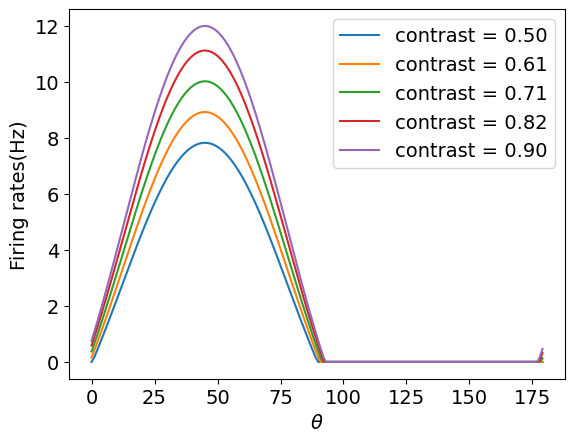

In [13]:
contrast = np.linspace(0.5,0.9,20)
index = [0,5,10,15,19]
for i in index:
    plt.plot(response_record_contrast[i],label=f'contrast = {contrast[i]:.2f}')
plt.legend()
plt.ylabel('Firing rates(Hz)')
plt.xlabel(r'$\theta$')

Text(0.5, 0, '$\\theta$')

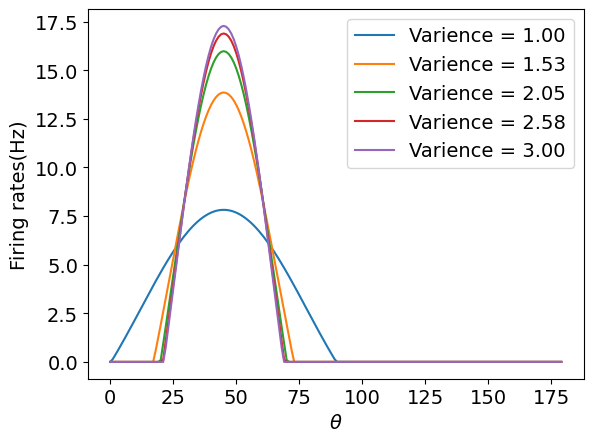

In [14]:
y_enlarge = np.linspace(1,3,20)
index = [0,5,10,15,19]
for i in index:
    plt.plot(response_record_var[i],label=f'Varience = {y_enlarge[i]:.2f}')
plt.legend()
plt.ylabel('Firing rates(Hz)')
plt.xlabel(r'$\theta$')

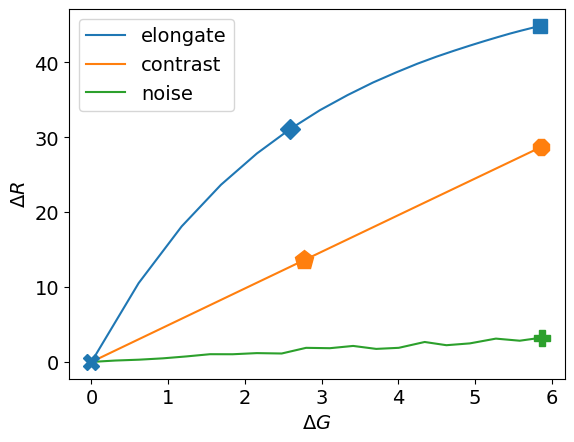

In [24]:
plt.plot(delta_gabor_record_var,delta_response_record_var,'-',label='elongate')
plt.plot(delta_gabor_record_contrast,delta_response_record_contrast,'-',label='contrast')
plt.plot(delta_gabor_record_gauss,delta_response_record_gauss,'-',label='noise')
plt.legend()
plt.xlabel(r'$\Delta G$')
plt.ylabel(r'$\Delta R$')
plt.plot(delta_gabor_record_var[0],delta_response_record_var[0],marker='X',color='#1f77b1',markersize=12)
plt.plot(delta_gabor_record_var[5],delta_response_record_var[5],marker='D',color='#1f77b4',markersize=10)
plt.plot(delta_gabor_record_var[-1],delta_response_record_var[-1],marker='s',color='#1f77b4',markersize=10)
plt.plot(delta_gabor_record_contrast[9],delta_response_record_contrast[9],'p',color='#ff7f0e',markersize=14)
plt.plot(delta_gabor_record_contrast[-1],delta_response_record_contrast[-1],'8',color='#ff7f0e',markersize=13)
plt.plot(delta_gabor_record_gauss[-1],delta_response_record_gauss[-1],'P',color='#2ca02c',markersize=12)
plt.savefig("all_gain.pdf", format="pdf")

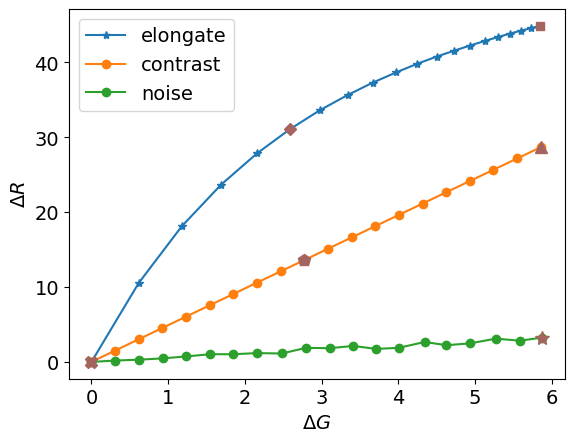

In [16]:
plt.plot(delta_gabor_record_var,delta_response_record_var,'*-',label='elongate')
plt.plot(delta_gabor_record_contrast,delta_response_record_contrast,'o-',label='contrast')
plt.plot(delta_gabor_record_gauss,delta_response_record_gauss,'o-',label='noise')
plt.legend()
plt.xlabel(r'$\Delta G$')
plt.ylabel(r'$\Delta R$')
custom_colors = ['#a5645f', '#7f7f7f', '#7f7f7f']
plt.plot(delta_gabor_record_var[0],delta_response_record_var[0],marker='X',color=custom_colors[0],markersize=8)
plt.plot(delta_gabor_record_var[5],delta_response_record_var[5],marker='D',color=custom_colors[0],markersize=6.5)
plt.plot(delta_gabor_record_var[-1],delta_response_record_var[-1],marker='s',color=custom_colors[0],markersize=6.35)
plt.plot(delta_gabor_record_contrast[9],delta_response_record_contrast[9],'p',color=custom_colors[0],markersize=9)
plt.plot(delta_gabor_record_contrast[-1],delta_response_record_contrast[-1],'^',color=custom_colors[0],markersize=8)
plt.plot(delta_gabor_record_gauss[-1],delta_response_record_gauss[-1],'*',color=custom_colors[0],markersize=10)

In [17]:
delta_gabor_record_gauss

array([0.        , 0.31284217, 0.61877827, 0.93086354, 1.23537107,
       1.54732241, 1.84141941, 2.15553218, 2.48030229, 2.79813602,
       3.10794507, 3.41168125, 3.71257709, 4.00637424, 4.34460056,
       4.6279542 , 4.93301784, 5.27287586, 5.58359948, 5.87874382])

In [33]:
G = torch.from_numpy(RotationalFiltersObtainer.gabor_filters_matrix())
K = K_XY(N,theta,1,sigma=25)
ring0 = Model(G,0,0,0,K,bias = -30,iterations=2000)

In [22]:
# variable_ranges = {'cos_freq': [0,0.75,1,1.5,2,2.25,3,3.5,4]}
# variable_ranges = {'y_enlarge_factor':np.linspace(1,3,10)}
# variable_ranges = {'x_enlarge_factor':[0.5,0.75,1,1.25,1.5,2]}
# variable_ranges = {'theta':[0,torch.pi/6,torch.pi/4,torch.pi/3,torch.pi/2]}
# variable_ranges = {'cos_phase':[0,torch.pi/6,torch.pi/4,torch.pi/3,torch.pi/2]}
variable_ranges = {'contrast':np.linspace(0.5,0.753,20)}

fixed_params = {
    'cos_phase': 0,
    'gaussian_var': 0.3,
    'gaussian_aspect_ratio': 1,
    'theta': np.pi/4,
    'contrast': 0.5,
    'cos_freq': 1.1,
    'y_enlarge_factor': 0.9,
    'x_enlarge_factor': 1.2
}

delta_gabor_record_contrast0,delta_response_record_contrast0,delta_response_record_contrast01,response_record_contrast0 = plot_gain(ring0, variable_ranges, fixed_params,norm=2)

torch.Size([65])
torch.Size([65])
torch.Size([67])
torch.Size([69])
torch.Size([71])
torch.Size([73])
torch.Size([75])
torch.Size([77])
torch.Size([79])
torch.Size([81])
torch.Size([81])
torch.Size([83])
torch.Size([85])
torch.Size([87])
torch.Size([87])
torch.Size([89])
torch.Size([91])
torch.Size([91])
torch.Size([93])
torch.Size([95])
torch.Size([95])


In [35]:
variable_ranges = {'y_enlarge_factor':np.linspace(0.9,4,20)}

delta_gabor_record_var0,delta_response_record_var0,delta_response_record_var01,response_record_var0 = plot_gain(ring0, variable_ranges, fixed_params,norm=2)

torch.Size([65])
torch.Size([65])
torch.Size([63])
torch.Size([63])
torch.Size([61])
torch.Size([61])
torch.Size([61])
torch.Size([59])
torch.Size([59])
torch.Size([59])
torch.Size([59])
torch.Size([59])
torch.Size([57])
torch.Size([57])
torch.Size([57])
torch.Size([57])
torch.Size([57])
torch.Size([57])
torch.Size([57])
torch.Size([57])
torch.Size([57])


In [36]:
scale = np.linspace(0,0.092,20)
variable_ranges = {'Gaussian_noise_scale':scale}

delta_gabor_record_gauss0,delta_response_record_gauss0,delta_response_record_gauss01,response_record_gauss0 = plot_gain(ring0, variable_ranges, fixed_params,norm=2)

torch.Size([65])
torch.Size([65])
torch.Size([65])
torch.Size([65])
torch.Size([65])
torch.Size([65])
torch.Size([65])
torch.Size([65])
torch.Size([65])
torch.Size([65])
torch.Size([65])
torch.Size([65])
torch.Size([65])
torch.Size([65])
torch.Size([65])
torch.Size([65])
torch.Size([65])
torch.Size([64])
torch.Size([65])
torch.Size([65])
torch.Size([65])
torch.Size([65])
torch.Size([64])
torch.Size([65])
torch.Size([64])
torch.Size([65])
torch.Size([65])
torch.Size([65])
torch.Size([65])
torch.Size([65])
torch.Size([65])
torch.Size([64])
torch.Size([65])
torch.Size([65])
torch.Size([64])
torch.Size([65])
torch.Size([65])
torch.Size([64])
torch.Size([64])
torch.Size([65])
torch.Size([65])
torch.Size([64])
torch.Size([65])
torch.Size([64])
torch.Size([66])
torch.Size([65])
torch.Size([64])
torch.Size([65])
torch.Size([64])
torch.Size([65])
torch.Size([64])
torch.Size([64])
torch.Size([65])
torch.Size([65])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([65

In [ ]:
plt.plot(delta_gabor_record_var,delta_response_record_var,'-',label='elongate')
plt.plot(delta_gabor_record_contrast,delta_response_record_contrast,'-',label='contrast')
plt.plot(delta_gabor_record_gauss,delta_response_record_gauss,'-',label='noise')
plt.legend()
plt.xlabel(r'$\|\Delta gabor\|$')
plt.ylabel(r'$\|\Delta response\|$')
plt.plot(delta_gabor_record_var[0],delta_response_record_var[0],marker='X',color='#1f77b1',markersize=12)
plt.plot(delta_gabor_record_var[5],delta_response_record_var[5],marker='D',color='#1f77b4',markersize=10)
plt.plot(delta_gabor_record_var[-1],delta_response_record_var[-1],marker='s',color='#1f77b4',markersize=10)
plt.plot(delta_gabor_record_contrast[9],delta_response_record_contrast[9],'p',color='#ff7f0e',markersize=14)
plt.plot(delta_gabor_record_contrast[-1],delta_response_record_contrast[-1],'8',color='#ff7f0e',markersize=13)
plt.plot(delta_gabor_record_gauss[-1],delta_response_record_gauss[-1],'P',color='#2ca02c',markersize=12)

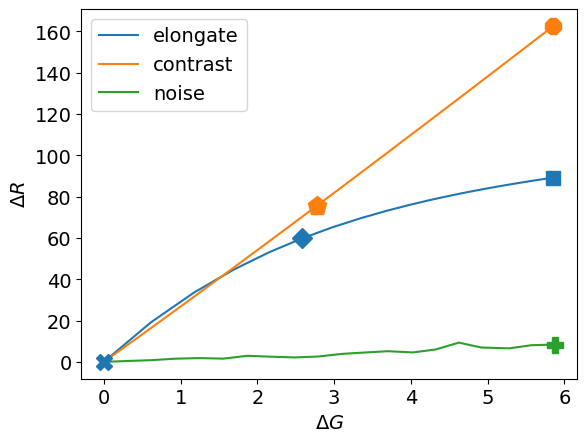

In [37]:
plt.plot(delta_gabor_record_var0,delta_response_record_var0,'-',label='elongate')
plt.plot(delta_gabor_record_contrast0,delta_response_record_contrast0,'-',label='contrast')
plt.plot(delta_gabor_record_gauss0,delta_response_record_gauss0,'-',label='noise')
plt.legend()
plt.xlabel(r'$\Delta G$')
plt.ylabel(r'$\Delta R$')
plt.plot(delta_gabor_record_var0[0],delta_response_record_var0[0],marker='X',color='#1f77b1',markersize=12)
plt.plot(delta_gabor_record_var0[5],delta_response_record_var0[5],marker='D',color='#1f77b4',markersize=10)
plt.plot(delta_gabor_record_var0[-1],delta_response_record_var0[-1],marker='s',color='#1f77b4',markersize=10)
plt.plot(delta_gabor_record_contrast0[9],delta_response_record_contrast0[9],'p',color='#ff7f0e',markersize=14)
plt.plot(delta_gabor_record_contrast0[-1],delta_response_record_contrast0[-1],'8',color='#ff7f0e',markersize=13)
plt.plot(delta_gabor_record_gauss0[-1],delta_response_record_gauss0[-1],'P',color='#2ca02c',markersize=12)
# plt.plot(delta_gabor_record_var0[0],delta_response_record_var0[0],marker='X',color=custom_colors[0],markersize=8)
# plt.plot(delta_gabor_record_var0[5],delta_response_record_var0[5],marker='D',color=custom_colors[0],markersize=6.5)
# plt.plot(delta_gabor_record_var0[-1],delta_response_record_var0[-1],marker='s',color=custom_colors[0],markersize=6.35)
# plt.plot(delta_gabor_record_contrast0[9],delta_response_record_contrast0[9],'p',color=custom_colors[0],markersize=9)
# plt.plot(delta_gabor_record_contrast0[-1],delta_response_record_contrast0[-1],'^',color=custom_colors[0],markersize=8)
# plt.plot(delta_gabor_record_gauss0[-1],delta_response_record_gauss0[-1],'*',color=custom_colors[0],markersize=10)
plt.savefig("no_gain.pdf", format="pdf")

In [ ]:
k, b = np.polyfit(delta_gabor_record_gauss, delta_response_record_gauss, 1)

# Output the result
print(f"Slop (k): {k}")
print(f"Intercept (b): {b}")

斜率 (k): 0.5043040354600623
截距 (b): 0.08627011248890458


In [ ]:
k0, b0 = np.polyfit(delta_gabor_record_gauss0, delta_response_record_gauss0, 1)

# Output the result
print(f"Slop (k): {k0}")
print(f"Intercept (b): {b0}")

斜率 (k): 1.648665678724755
截距 (b): 0.14110033199539251


/var/folders/5c/hn4yb8vx47sbcl9pdt29wc240000gn/T/ipykernel_20035/3307686334.py:3: RuntimeWarning: invalid value encountered in divide
  plt.plot(delta_gabor_record_var[1:],(delta_response_record_var/deltadelta_response_record_gauss_estimate_var)[1:],'*-',label='all connections, elongate/noise')
/var/folders/5c/hn4yb8vx47sbcl9pdt29wc240000gn/T/ipykernel_20035/3307686334.py:4: RuntimeWarning: invalid value encountered in divide
  plt.plot(delta_gabor_record_var0[1:],(delta_response_record_var0/deltadelta_response_record_gauss_estimate_var0)[1:],'*-',label='no connection, elongate/noise')
/var/folders/5c/hn4yb8vx47sbcl9pdt29wc240000gn/T/ipykernel_20035/3307686334.py:8: RuntimeWarning: invalid value encountered in divide
  plt.plot(delta_gabor_record_contrast[1:],(delta_response_record_contrast/deltadelta_response_record_gauss_estimate_contrast)[1:],'o-',label='all connections, contrast/noise')
/var/folders/5c/hn4yb8vx47sbcl9pdt29wc240000gn/T/ipykernel_20035/3307686334.py:9: RuntimeWarning

Text(0, 0.5, '$\\Delta R$')

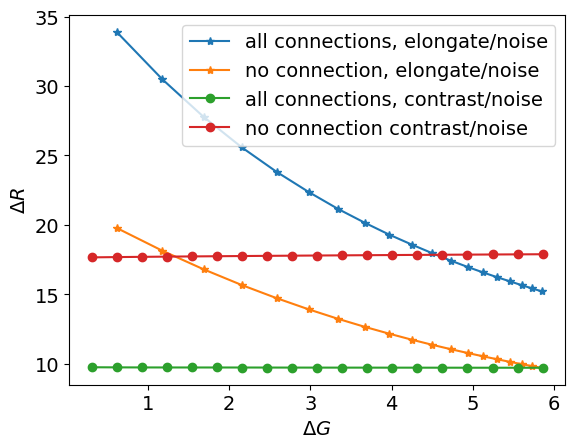

In [193]:
deltadelta_response_record_gauss_estimate_var = k*delta_gabor_record_var
deltadelta_response_record_gauss_estimate_var0 = k0*delta_gabor_record_var0
plt.plot(delta_gabor_record_var[1:],(delta_response_record_var/deltadelta_response_record_gauss_estimate_var)[1:],'*-',label='all connections, elongate/noise')
plt.plot(delta_gabor_record_var0[1:],(delta_response_record_var0/deltadelta_response_record_gauss_estimate_var0)[1:],'*-',label='no connection, elongate/noise')

deltadelta_response_record_gauss_estimate_contrast = k*delta_gabor_record_contrast
deltadelta_response_record_gauss_estimate_contrast0 = k0*delta_gabor_record_contrast0
plt.plot(delta_gabor_record_contrast[1:],(delta_response_record_contrast/deltadelta_response_record_gauss_estimate_contrast)[1:],'o-',label='all connections, contrast/noise')
plt.plot(delta_gabor_record_contrast0[1:],(delta_response_record_contrast0/deltadelta_response_record_gauss_estimate_contrast0)[1:],'o-',label='no connection contrast/noise')
plt.legend()
plt.xlabel(r'$\Delta G$')
plt.ylabel(r'$\Delta R$')

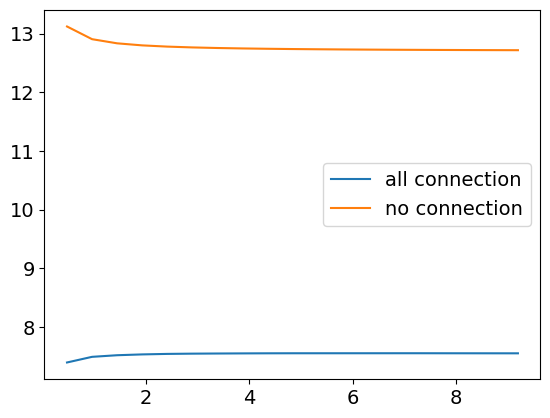

In [26]:
deltadelta_response_record_gauss_estimate_contrast = k*delta_gabor_record_contrast+b
deltadelta_response_record_gauss_estimate_contrast0 = k0*delta_gabor_record_contrast0+b0
plt.plot(delta_gabor_record_contrast[1:],(delta_response_record_contrast/deltadelta_response_record_gauss_estimate_contrast)[1:],label='all connection')
plt.plot(delta_gabor_record_contrast0[1:],(delta_response_record_contrast0/deltadelta_response_record_gauss_estimate_contrast0)[1:],label='no connection')
plt.legend()

Text(0, 0.5, 'delta_response')

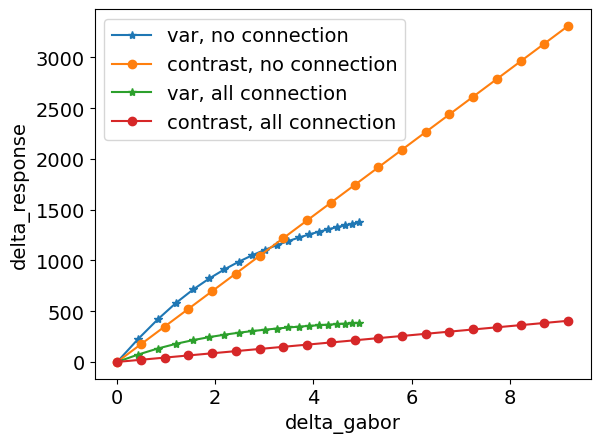

In [27]:
plt.plot(delta_gabor_record_var0,delta_response_record_var01,'*-',label='var, no connection')
plt.plot(delta_gabor_record_contrast0,delta_response_record_contrast01,'o-',label='contrast, no connection')
plt.plot(delta_gabor_record_var,delta_response_record_var1,'*-',label='var, all connection')
plt.plot(delta_gabor_record_contrast,delta_response_record_contrast1,'o-',label='contrast, all connection')
plt.legend()
plt.xlabel('delta_gabor')
plt.ylabel('delta_response')